In [1]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 26.1 MB/s eta 0:00:00


In [2]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 6.2 MB/s eta 0:00:00


<a href="https://colab.research.google.com/github/thadduslee/EGARCH-model-XGBoost-optimal-portfolio-construction-Markowitz-Portfolio-Theory-Monte-Carlo/blob/main/Fintech_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import yfinance as yf
import numpy as np
from arch import arch_model
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Reddit scraping bot

In [ ]:
#def reddit_scraper(ticker):

Sentiment Analysis Engine

In [ ]:
#def sentiment_analysis(ticker):

Volatility Prediction

In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GMMHMM
import matplotlib.pyplot as plt
import seaborn as sns

def hidden_markov_model_gmm(ticker):
    # 1. Get Data
    data = yf.download(ticker, start="2015-01-01", progress=False)
    # Handle multi-index if necessary
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, level=1, axis=1) if ticker in data.columns.levels[1] else data

    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)

    X = data['Log_Returns'].values.reshape(-1, 1)

    # 2. Setup GMMHMM
    # n_mix=2: Each state is a mix of 2 Gaussian distributions (helps capture fat tails)
    model = GMMHMM(n_components=3, n_mix=2, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(X)

    # 3. Fix Sorting Logic (The tricky part)
    # GMMHMM has dimensions (n_components, n_mix, n_features)

    # We calculate the weighted variance for each state to sort them
    # effective_var = sum(weight * variance) for each mixture in the state
    variances = []
    for i in range(model.n_components):
        # model.weights_[i] is shape (n_mix,)
        # model.covars_[i] is shape (n_mix, n_features)

        # We take the weighted average of the variances in this state
        weighted_var = np.dot(model.weights_[i], model.covars_[i])
        variances.append(weighted_var[0]) # [0] because we only have 1 feature (returns)

    variances = np.array(variances)

    # Sort Low -> High
    sorted_order = np.argsort(variances)
    reorder_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_order)}

    # Predict and Reorder
    hidden_states = model.predict(X)
    sorted_states = np.array([reorder_map[s] for s in hidden_states])
    data['Regime'] = sorted_states

    # 4. Print Parameters
    print(f"--- Regime Parameters for {ticker} (GMM-HMM) ---")
    regime_names = ['Low', 'Medium', 'High']

    for i in range(model.n_components):
        original_idx = sorted_order[i]

        # Calculate weighted mean and weighted std for display
        w_mean = np.dot(model.weights_[original_idx], model.means_[original_idx])[0]
        w_var = np.dot(model.weights_[original_idx], model.covars_[original_idx])[0]
        w_std = np.sqrt(w_var)

        print(f"Regime {i} ({regime_names[i]} Volatility):")
        print(f"  Weighted Mean: {w_mean:.5f}")
        print(f"  Weighted Vol (Std): {w_std:.5f}")
        print("-" * 30)

    # 5. Plotting
    plt.figure(figsize=(14, 8))
    colors = ['green', 'gold', 'red']

    # Plot price
    plt.plot(data.index, data['Close'], color='black', alpha=0.1)

    for i, color in enumerate(colors):
        mask = (data['Regime'] == i)
        # Use scatter to handle gaps better
        plt.scatter(data.index[mask], data['Close'][mask],
                   s=10, c=color, label=f"{regime_names[i]} Volatility", alpha=0.6, edgecolors='none')

    plt.title(f"GMM-HMM Regime Detection for {ticker}", fontsize=16)
    plt.ylabel("Price ($)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\nTransition Matrix (State i -> j):")
    print(model.transmat_[sorted_order, :][:, sorted_order])
    return data["Regime"]



In [27]:
import numpy as np

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) #size = sample, time steps, features



/tmp/ipython-input-976912667.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1519962032.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for aapl (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00194
  Weighted Vol (Std): 0.01109
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00130
  Weighted Vol (Std): 0.01366
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: -0.00054
  Weighted Vol (Std): 0.02561
------------------------------


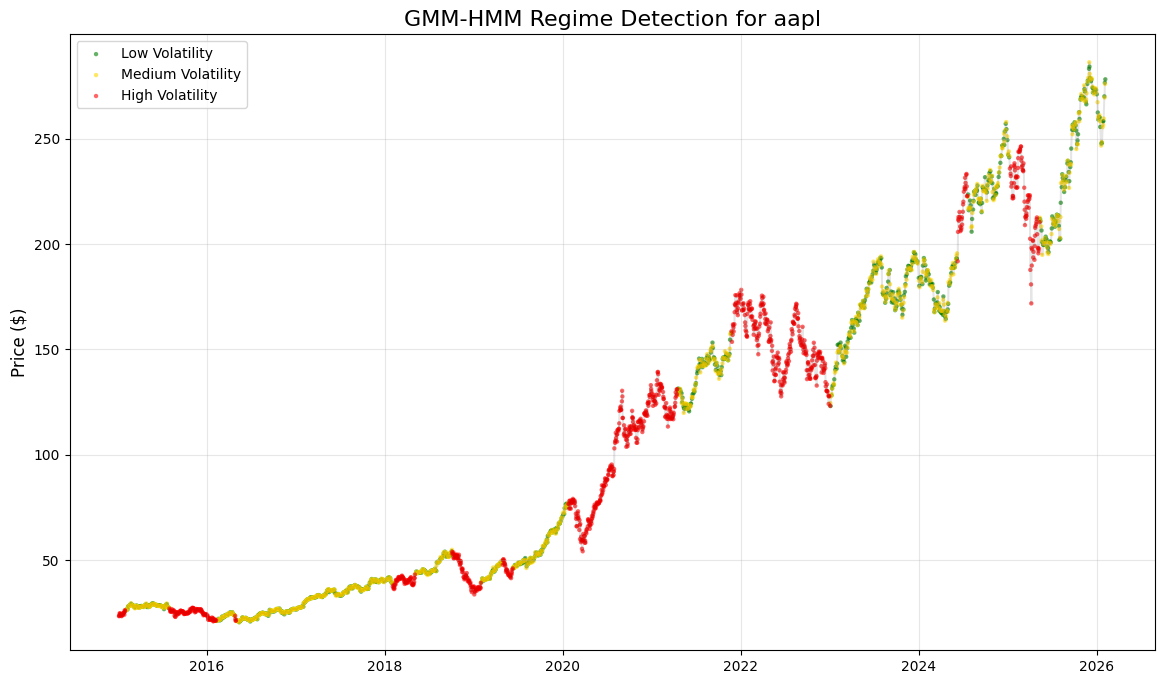


Transition Matrix (State i -> j):
[[2.97763416e-05 9.99695817e-01 2.74406637e-04]
 [9.78520443e-01 9.59243783e-05 2.13836329e-02]
 [5.99217228e-03 1.57880704e-02 9.78219757e-01]]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.1351 - val_loss: 0.4120
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6425 - val_loss: 0.3821
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6086 - val_loss: 0.3807
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5711 - val_loss: 0.3785
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5937 - val_loss: 0.3789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Predicted Daily Vol: 1.1353%
Predicted Annualized Vol: 18.0226%


np.float64(18.02264166373302)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def predict_next_day_volatility(ticker):
  data = yf.download(ticker, start = "2015-01-01")
  data["regime"] = hidden_markov_model_gmm(ticker)
  data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1)) * 100
  #add in your sentiment anaylsis function here
  #data["sentiment"] = sentiment_analysis(ticker)
  window = 5
  indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=window)
  data["target_volatility"] = data["log_returns"].rolling(window = indexer).std().shift(-1)

  data["volatility_lag_week"] = data["log_returns"].rolling(5).std().shift(1)
  data["volatility_lag_month"] = data["log_returns"].rolling(22).std().shift(1)
  data["volatility_lag_quarter"] = data["log_returns"].rolling(66).std().shift(1)

  data["absolute_returns_lag"] = abs(data["log_returns"].shift(1))
  log_hl = np.log(data["High"] / data["Low"])
  log_co = np.log(data["Close"] / data["Open"])
  # Ensure the argument to sqrt is non-negative to prevent NaNs
  data["garman_klass"] = np.sqrt(np.maximum(0, 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2)) * 100

  data["vol_change"] = data["Volume"].pct_change()
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
  data.dropna(inplace = True)

  #split into training and testing data
  training = data.iloc[:int(len(data)*0.8)].copy()
  testing = data.iloc[int(len(data)*0.8):].copy()

  training_garch_model = arch_model(training["log_returns"]- training["log_returns"].mean() , vol = "EGARCH", p = 1, q = 1, dist = "t")
  training_garch_model_fit = training_garch_model.fit(disp = "off")
  training["garch_volatility"] = training_garch_model_fit.conditional_volatility

  testing_garch_model = arch_model(testing["log_returns"] - training["log_returns"].mean(), vol = "EGARCH", p = 1, q = 1, dist = "t")
  testing_garch_model_fix = testing_garch_model.fix(training_garch_model_fit.params)
  testing["garch_volatility"] = testing_garch_model_fix.conditional_volatility

  #add in sentiment as a feature
  features = ["log_returns", "volatility_lag_week", "volatility_lag_month", "volatility_lag_quarter", "garch_volatility", "absolute_returns_lag", "vol_change", "garman_klass", "regime"]

  X_train = training[features]
  y_train = training["target_volatility"]

  X_test = testing[features]
  y_test = testing["target_volatility"]

  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)


  X_train, y_train = create_sequences(X_train, y_train)
  X_test, y_test = create_sequences(X_test, y_test)

  #train on first 90% of data, evaluate on last 10%
  val_split = int(len(X_train) * 0.9)
  X_tr, X_val = X_train[:val_split], X_train[val_split:]
  y_tr, y_val = y_train[:val_split], y_train[val_split:]

  model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_tr.shape[1], X_tr.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

  model.compile(optimizer='adam', loss='mae') # MAE is often better for volatility than MSE

  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit(X_tr, y_tr,
              validation_data=(X_val, y_val),
              epochs=5,
              batch_size=32, #sends it in batches of 32
              callbacks=[early_stop],
              verbose=1)

  full_data = pd.concat([training, testing], axis=0)

    # Calculate GARCH for the very last step (Forecast)
  full_garch = arch_model(full_data["log_returns"] - full_data["log_returns"].mean(), vol="EGARCH", p=1, q=1, dist="t")
  full_garch_fit = full_garch.fix(training_garch_model_fit.params)
  # Get the 1-step ahead forecast variance
  next_day_garch_vol = full_garch_fit.forecast(horizon=1).variance.iloc[-1].values[0]**0.5

  # We need the last SEQ_LEN rows to predict tomorrow
  last_sequence_df = full_data.iloc[-10:].copy()

  # IMPORTANT: Update the last row's GARCH feature with the FORECASTED GARCH value
  # This is crucial because 'garch_volatility' in the df is historical conditional vol,
  # but for tomorrow we need the forecast.
  last_sequence_df.iloc[-1, last_sequence_df.columns.get_loc("garch_volatility")] = next_day_garch_vol

  # Scale this sequence
  last_sequence_scaled = scaler.transform(last_sequence_df[features])

  # Reshape for LSTM: (1 sample, SEQ_LEN time steps, n features)
  last_sequence_reshaped = last_sequence_scaled.reshape(1, 10, len(features))

  predicted_daily_vol = model.predict(last_sequence_reshaped)[0][0]
  annualised_vol = predicted_daily_vol * np.sqrt(252)

  print(f"Predicted Daily Vol: {predicted_daily_vol:.4f}%")
  print(f"Predicted Annualized Vol: {annualised_vol:.4f}%")

  return annualised_vol
predict_next_day_volatility("aapl")

Enter a stock (Q to quit): aapl
Enter a stock (Q to quit): ko
Enter a stock (Q to quit): pltr
Enter a stock (Q to quit): q


/tmp/ipython-input-976912667.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1519962032.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for AAPL (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00194
  Weighted Vol (Std): 0.01109
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00130
  Weighted Vol (Std): 0.01366
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: -0.00054
  Weighted Vol (Std): 0.02561
------------------------------


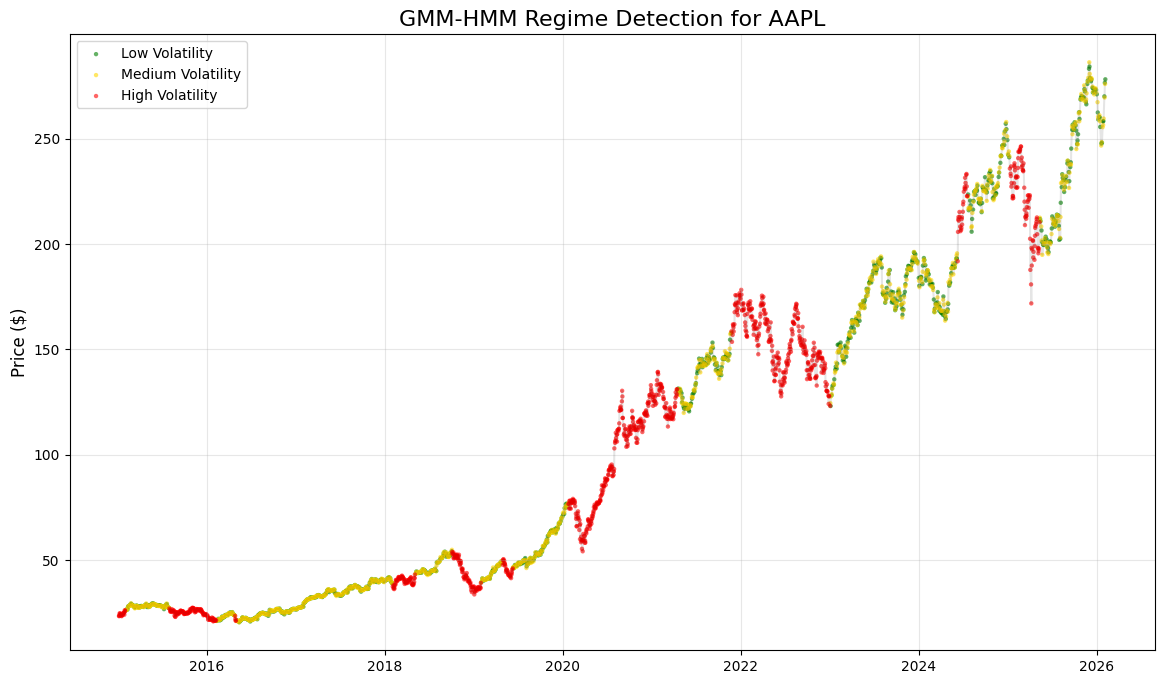


Transition Matrix (State i -> j):
[[2.98687562e-05 9.99695701e-01 2.74430725e-04]
 [9.78520256e-01 9.62163110e-05 2.13835275e-02]
 [5.99453490e-03 1.57858460e-02 9.78219619e-01]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0950 - val_loss: 0.4759
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6512 - val_loss: 0.3937
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6223 - val_loss: 0.3677
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6102 - val_loss: 0.3866
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6010 - val_loss: 0.3804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted Daily Vol: 1.1381%
Predicted Annualized Vol: 18.0675%


/tmp/ipython-input-976912667.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1519962032.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for KO (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00071
  Weighted Vol (Std): 0.00791
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00041
  Weighted Vol (Std): 0.00792
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: -0.00050
  Weighted Vol (Std): 0.01947
------------------------------


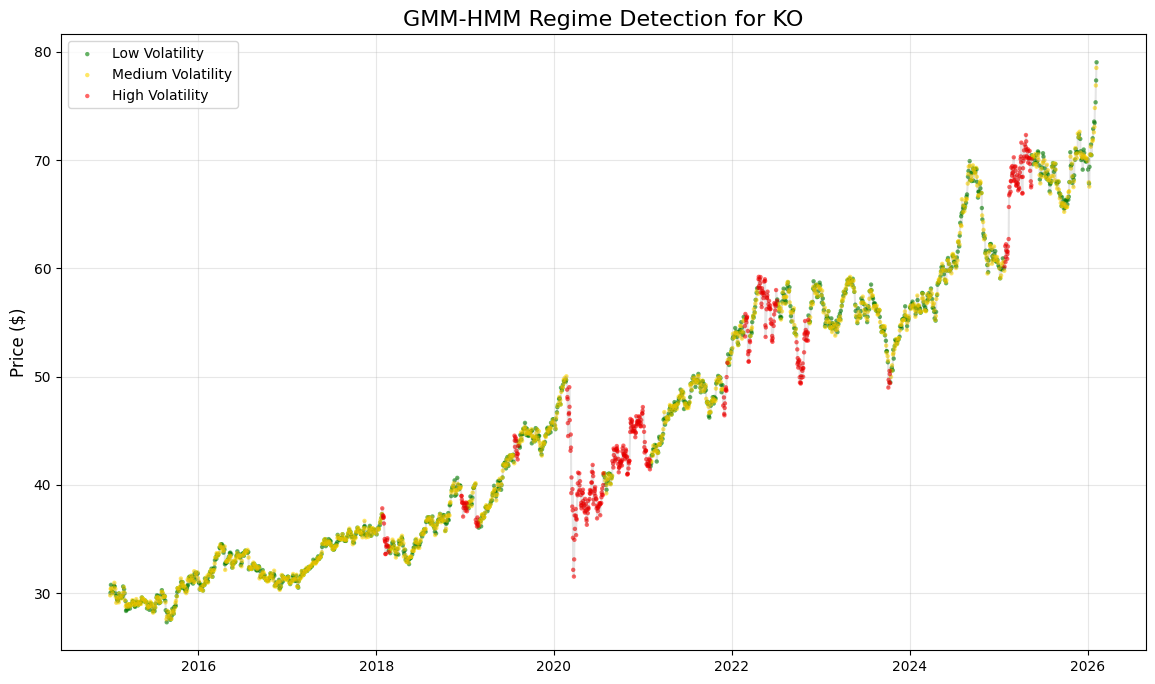


Transition Matrix (State i -> j):
[[6.12044817e-04 9.99375393e-01 1.25624933e-05]
 [9.60484794e-01 1.27269641e-02 2.67882423e-02]
 [4.12759327e-02 1.29817798e-02 9.45742288e-01]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6797 - val_loss: 0.2670
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3759 - val_loss: 0.2936
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3816 - val_loss: 0.2564
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3689 - val_loss: 0.2606
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3463 - val_loss: 0.2810
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


/tmp/ipython-input-976912667.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed

Predicted Daily Vol: 0.7277%
Predicted Annualized Vol: 11.5524%



/tmp/ipython-input-1519962032.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for PLTR (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00044
  Weighted Vol (Std): 0.03066
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00315
  Weighted Vol (Std): 0.04541
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: 0.00546
  Weighted Vol (Std): 0.05957
------------------------------


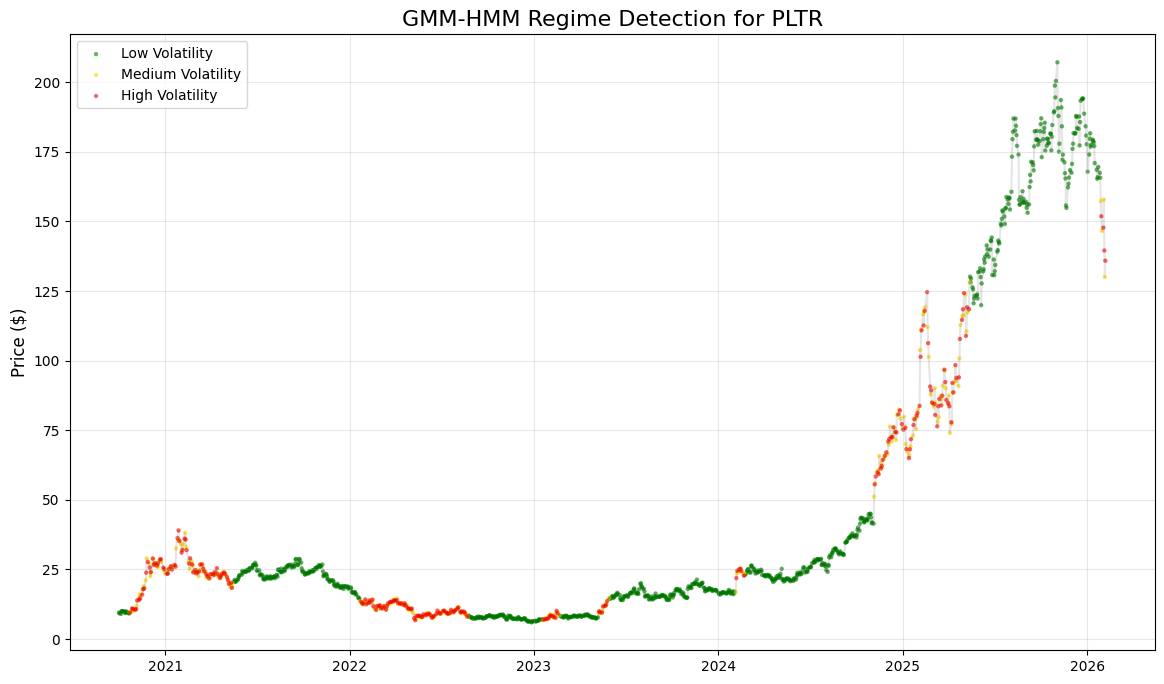


Transition Matrix (State i -> j):
[[9.80428886e-01 1.36443181e-02 5.92679633e-03]
 [5.24403403e-02 4.89572005e-02 8.98602459e-01]
 [1.48641649e-04 9.94385758e-01 5.46560066e-03]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2915 - val_loss: 1.9468
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4663 - val_loss: 1.5167
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4474 - val_loss: 1.5161
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2961 - val_loss: 1.5665
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3067 - val_loss: 1.5309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


/tmp/ipython-input-244512424.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(stocks, start="1900-01-01")["Close"]
[                       0%                       ]

Predicted Daily Vol: 3.0398%
Predicted Annualized Vol: 48.2551%


[*********************100%***********************]  3 of 3 completed


In [31]:
stocks = []
adding = True
while adding:
  temp = input("Enter a stock (Q to quit): ")
  if temp == "Q" or temp == "q":
    adding = False
  else:
    stocks.append(temp.upper()) # Convert to uppercase here
predicted_annual_volatilities = []
for stock in stocks:
  predicted_annual_volatilities.append(predict_next_day_volatility(stock))

price_data = yf.download(stocks, start="1900-01-01")["Close"]
returns_data = np.log(price_data / price_data.shift(1))
returns_data.dropna(inplace = True)
correlation_matrix = returns_data.corr()
correlation_matrix = correlation_matrix.loc[stocks, stocks]
 #get historical correlation

In [32]:
D = np.diag(np.array(predicted_annual_volatilities) / 100)


future_covariance_matrix = D @ correlation_matrix @ D

print("\n--- Future Covariance Matrix (Annualized) ---")
print(future_covariance_matrix)


--- Future Covariance Matrix (Annualized) ---
          0         1         2
0  0.032643  0.005429  0.030914
1  0.005429  0.013346 -0.001703
2  0.030914 -0.001703  0.232855


Monte Carlo Simulation (1000 runs)

In [33]:
returns = []
volatilities = []
allocations = []

num_stocks = len(stocks)
num_portfolios = 1000

mean_daily_returns = returns_data.mean()
mean_annual_returns = mean_daily_returns * 252
mean_annual_returns = mean_annual_returns[stocks]

In [34]:
for port in range(num_portfolios):
  w = np.random.random(num_stocks)
  w /= np.sum(w) #make it sum to 1
  allocations.append(w)
  returns.append(np.dot(w, mean_annual_returns))

  var = np.transpose(w).dot(future_covariance_matrix).dot(w)
  standard_deviation = np.sqrt(var)
  volatilities.append(standard_deviation)

In [35]:
data2 = {"Returns":returns, "Volatilities": volatilities}
for counter, symbol in enumerate(stocks):
  data2[symbol + " Weight"] = [allocation[counter] for allocation in allocations]

portfolio = pd.DataFrame(data2)
portfolio

,Returns,Volatilities,AAPL Weight,KO Weight,PLTR Weight
0,0.302276,0.246709,0.459548,0.118887,0.421564
1,0.432041,0.397803,0.025214,0.153617,0.821169
2,0.286929,0.229450,0.466447,0.153209,0.380344
3,0.192964,0.153321,0.657010,0.235169,0.107821
4,0.171467,0.128311,0.509041,0.419463,0.071496
...,...,...,...,...,...
995,0.171414,0.120912,0.394761,0.518358,0.086881
996,0.216861,0.148484,0.046858,0.699713,0.253429
997,0.274115,0.209344,0.313685,0.318853,0.367462
998,0.134380,0.108736,0.076587,0.890518,0.032895


Below is a plot of the efficient frontier

<Axes: xlabel='Volatilities', ylabel='Returns'>

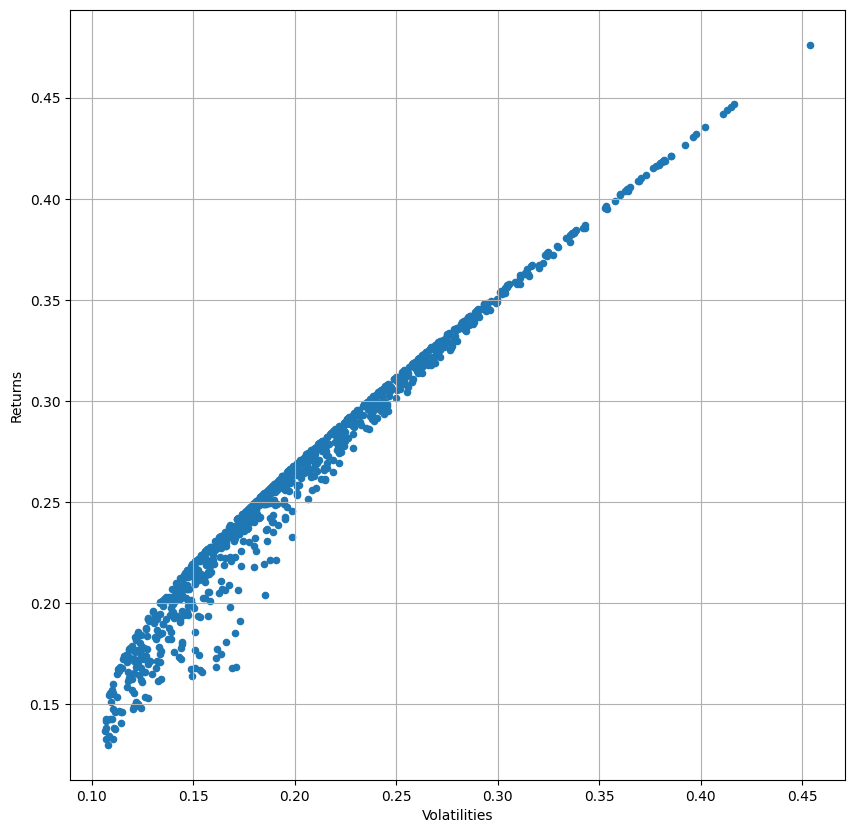

In [36]:
portfolio.plot.scatter(x = 'Volatilities', y = "Returns", figsize = (10,10), grid = True)


In [37]:
risk_free_rate = 0.04
highest_sharpe_ratio = portfolio.iloc[((portfolio["Returns"] - risk_free_rate)/portfolio["Volatilities"]).idxmax()]
highest_sharpe_ratio

,231
Returns,0.212379
Volatilities,0.143618
AAPL Weight,0.126536
KO Weight,0.642623
PLTR Weight,0.230841


The portfolio with the highest sharpe ratio is marked below with a star

/tmp/ipython-input-2200269511.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x = highest_sharpe_ratio[1], y = highest_sharpe_ratio[0], color = "red", marker = "*", s = 500)


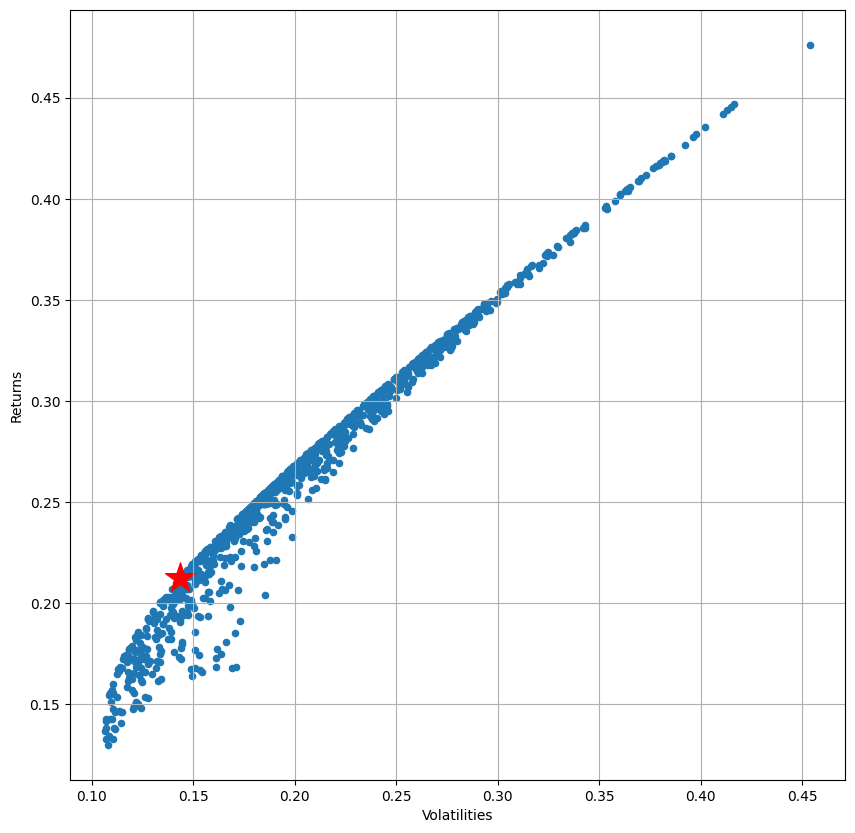

In [38]:
portfolio.plot.scatter(x = 'Volatilities', y = "Returns", figsize = (10,10), grid = True)
plt.scatter(x = highest_sharpe_ratio[1], y = highest_sharpe_ratio[0], color = "red", marker = "*", s = 500)


In [39]:
print(f"The expected returns for the portfolio with the highest sharpe ratio is: {highest_sharpe_ratio.iloc[0]*100}%")
print(f"The volatility for the portfolio with the highest sharpe ratio is: {highest_sharpe_ratio.iloc[1]*100}%")


The expected returns for the portfolio with the highest sharpe ratio is: 21.237901486158%
The volatility for the portfolio with the highest sharpe ratio is: 14.361758875797905%
